Iniciando carregamento e preparação dos dados...
Dados carregados. Análise focada em 18 municípios.

--- Executando Fase 1: Mapeamento de Zonas Críticas (IVE) ---

[Entregável 1.a] Tabela: Ranking de Municípios por IVE
            municipio             uf    ive  taxa_analfabetismo  taxa_cobertura_eja
4235         Itatuba        Paraíba   0.259               0.278               0.070
4207         Mogeiro        Paraíba   0.235               0.254               0.074
4239            Ingá        Paraíba   0.213               0.252               0.157
4307      Bananeiras        Paraíba   0.207               0.250               0.170
4324     Alagoa Nova        Paraíba   0.197               0.218               0.098
4124   Serra Redonda        Paraíba   0.157               0.216               0.275
4953      Santa Rita       Maranhão   0.146               0.156               0.065
4269        Caturité        Paraíba   0.141               0.164               0.137
4224      Lagoa Seca     

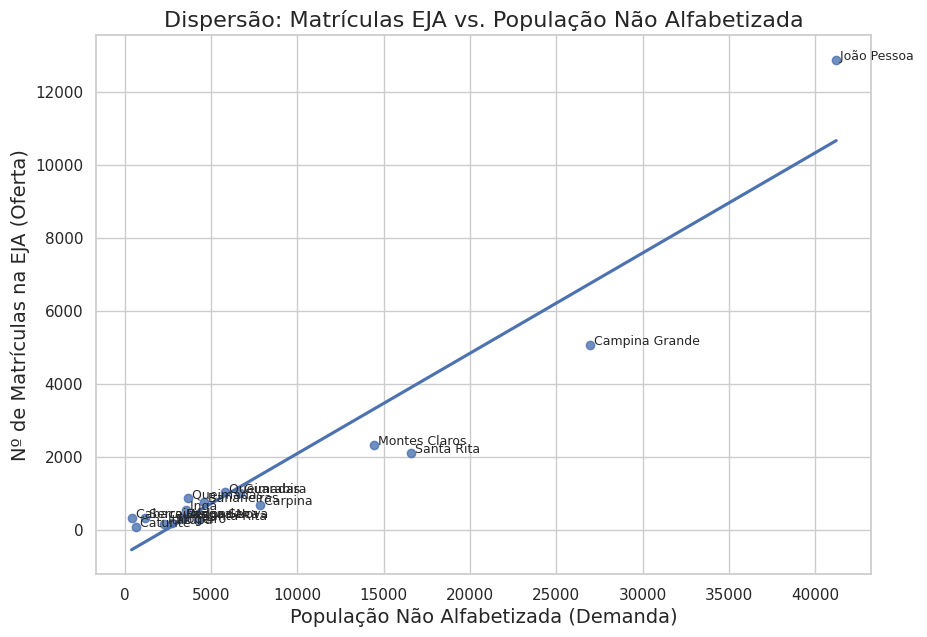


--- Executando Fase 2: Análise do Perfil Etário (Clusterização) ---


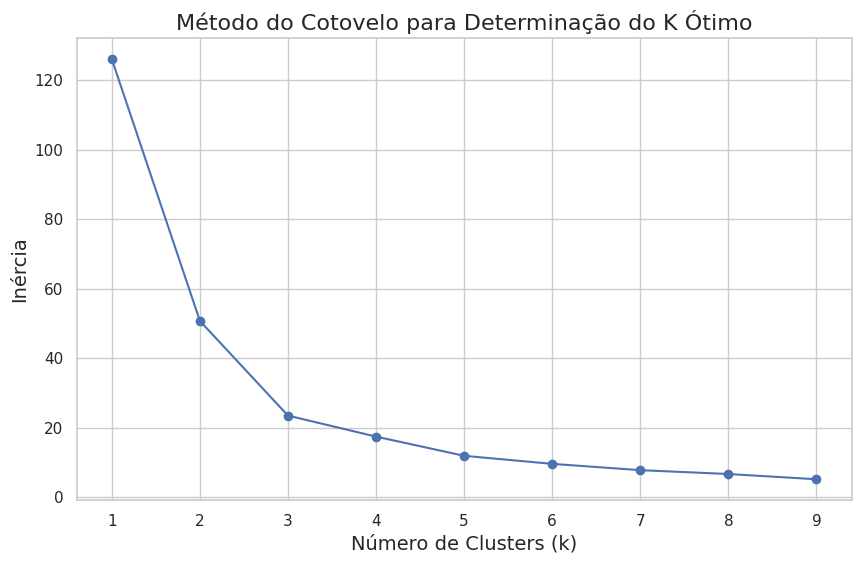


Com base no método do cotovelo, o k ótimo escolhido foi: 3

[Entregável 2.a] Caracterização dos Clusters:
         nao_alf_15_19  nao_alf_20_24  nao_alf_25_34  nao_alf_35_44  \
cluster                                                               
0                0.020          0.023          0.035          0.087   
1                0.028          0.028          0.034          0.079   
2                0.019          0.022          0.042          0.115   

         nao_alf_45_54  nao_alf_55_64  nao_alf_65_mais  
cluster                                                 
0                0.180          0.261            0.394  
1                0.168          0.249            0.414  
2                0.206          0.260            0.337  

Municípios por Perfil:
            municipio                       perfil_cluster
4235         Itatuba   Perfil: Força de Trabalho (Adultos)
4207         Mogeiro   Perfil: Força de Trabalho (Adultos)
4239            Ingá   Perfil: Força de Trabalho (A

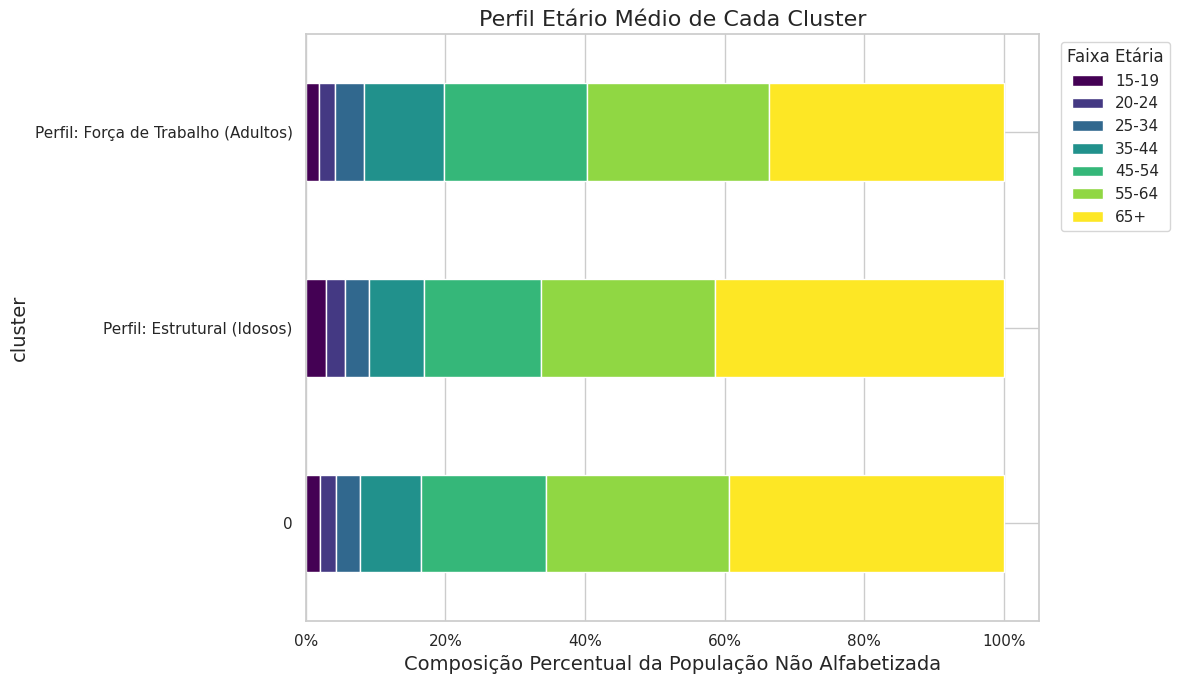


--- Executando Fase 3: Análise de Políticas Públicas ---
AVISO: Arquivo de pacto '/content/dados_pacto_federal.csv' não encontrado.
Usando dados SIMULADOS para a análise. Crie o arquivo para resultados reais.

Teste-t para o IVE (Aderentes vs. Não Aderentes): p-valor = 0.8340
Resultado: Não há evidência de diferença estatisticamente significativa entre os grupos.

[Entregável 3.a] Gerando Box Plot Comparativo do IVE...


/tmp/ipython-input-2276773106.py:176: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='aderiu_pacto', y='ive', palette='coolwarm')


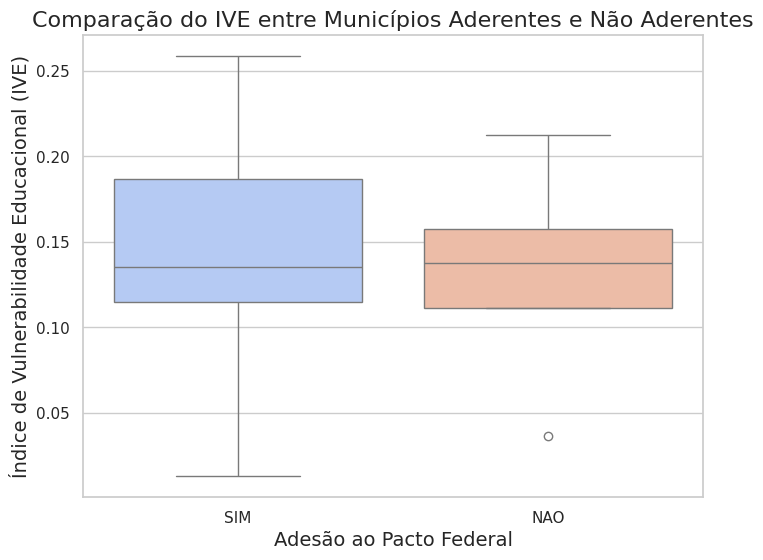


--- Executando Fase 4: Análise do Perfil Econômico ---
AVISO: Arquivo de dados econômicos '/content/dados_rais_municipios.csv' não encontrado.
Esta fase não pode ser executada sem os dados da RAIS/CAGED.


Análise metodológica completa concluída.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker

# ===================================================================
# --- FUNÇÕES DE ANÁLISE (FASES 1 a 4) ---
# ===================================================================

def carregar_e_preparar_dados(file_path, municipios_list):
    """Carrega e limpa o dataset principal da EJA."""
    print("Iniciando carregamento e preparação dos dados...")
    try:
        df_full = pd.read_excel(file_path, header=6)
    except FileNotFoundError:
        print(f"ERRO CRÍTICO: Arquivo principal '{file_path}' não encontrado.")
        return None

    rename_map = {
        'MUNICÍPIO': 'municipio', 'UF': 'uf',
        'POPULAÇÃO TOTAL DO MUNICÍPIO +15 anos \n(CENSO IBGE 2022)': 'populacao_total_15_mais',
        'POPULAÇÃO NÃO ALFABETIZADA (nº de pessoas)\n(CENSO IBGE 2022)': 'populacao_nao_alfabetizada',
        'Nº de matrículas de EJA - Fundamental + Médio \n(incluindo particulares)\n(CENSO ESCOLAR 2024)': 'matriculas_eja',
        '15 a 19 anos\n(% da população não alfabetizada)': 'nao_alf_15_19', '20 a 24 anos\n(% da população não alfabetizada)': 'nao_alf_20_24',
        '25 a 34 anos\n(% da população não alfabetizada)': 'nao_alf_25_34', '35 a 44 anos\n(% da população não alfabetizada)': 'nao_alf_35_44',
        '45 a 54 anos\n(% da população não alfabetizada)': 'nao_alf_45_54', '55 a 64 anos\n(% da população não alfabetizada)': 'nao_alf_55_64',
        '65 anos ou mais\n(% da população não alfabetizada)': 'nao_alf_65_mais'
    }
    df_full.rename(columns=rename_map, inplace=True)

    df_full['municipio_norm'] = df_full['municipio'].astype(str).str.strip().str.upper()
    municipios_selecionados_norm = [m.strip().upper() for m in municipios_list]

    df = df_full[df_full['municipio_norm'].isin(municipios_selecionados_norm)].copy()

    if df.empty:
        print("AVISO: Nenhum dos municípios selecionados foi encontrado.")
        return None

    print(f"Dados carregados. Análise focada em {len(df)} municípios.")
    return df

# --- FASE 1: MAPEAMENTO DE ZONAS CRÍTICAS (IVE) ---
def fase1_analise_ive(df):
    """Calcula o IVE e gera as visualizações da Fase 1."""
    print("\n--- Executando Fase 1: Mapeamento de Zonas Críticas (IVE) ---")

    numeric_cols = ['populacao_total_15_mais', 'populacao_nao_alfabetizada', 'matriculas_eja']
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df.dropna(subset=numeric_cols, inplace=True)

    epsilon = 1e-6
    df['taxa_analfabetismo'] = df['populacao_nao_alfabetizada'] / (df['populacao_total_15_mais'] + epsilon)
    df['taxa_cobertura_eja'] = (df['matriculas_eja'] / (df['populacao_nao_alfabetizada'] + epsilon)).clip(0, 1)
    df['ive'] = df['taxa_analfabetismo'] * (1 - df['taxa_cobertura_eja'])

    df_sorted = df.sort_values('ive', ascending=False)

    print("\n[Entregável 1.a] Tabela: Ranking de Municípios por IVE")
    print(df_sorted[['municipio', 'uf', 'ive', 'taxa_analfabetismo', 'taxa_cobertura_eja']].round(3).to_string())

    print("\n[Entregável 1.c] Gerando Gráfico de Dispersão: Matrículas vs. Pop. Não Alfabetizada")
    plt.figure(figsize=(10, 7))
    sns.regplot(data=df, x='populacao_nao_alfabetizada', y='matriculas_eja', ci=None)
    plt.title('Dispersão: Matrículas EJA vs. População Não Alfabetizada')
    plt.xlabel('População Não Alfabetizada (Demanda)')
    plt.ylabel('Nº de Matrículas na EJA (Oferta)')
    for i, row in df.iterrows():
        plt.text(row['populacao_nao_alfabetizada'], row['matriculas_eja'], f" {row['municipio']}", fontsize=9)
    plt.grid(True)
    plt.show()

    return df_sorted

# --- FASE 2: ANÁLISE DO PERFIL ETÁRIO (CLUSTERIZAÇÃO) ---
def fase2_analise_perfil_etario(df):
    """Executa a clusterização K-Means para segmentar os municípios."""
    print("\n--- Executando Fase 2: Análise do Perfil Etário (Clusterização) ---")

    cols_perfil = [
        'nao_alf_15_19', 'nao_alf_20_24', 'nao_alf_25_34', 'nao_alf_35_44',
        'nao_alf_45_54', 'nao_alf_55_64', 'nao_alf_65_mais'
    ]
    df_perfil = df[cols_perfil].copy()
    df_perfil.dropna(inplace=True)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_perfil)

    inertia = []
    k_range = range(1, 10)
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X_scaled)
        inertia.append(kmeans.inertia_)

    plt.figure(figsize=(10, 6))
    plt.plot(k_range, inertia, marker='o')
    plt.title('Método do Cotovelo para Determinação do K Ótimo')
    plt.xlabel('Número de Clusters (k)')
    plt.ylabel('Inércia')
    plt.grid(True)
    plt.show()

    k_otimo = 3
    print(f"\nCom base no método do cotovelo, o k ótimo escolhido foi: {k_otimo}")
    kmeans = KMeans(n_clusters=k_otimo, random_state=42, n_init=10)
    df['cluster'] = kmeans.fit_predict(X_scaled)

    cluster_profiles = df.groupby('cluster')[cols_perfil].mean()
    cluster_profiles_percent = cluster_profiles.div(cluster_profiles.sum(axis=1), axis=0)

    # Nomeação dinâmica dos clusters
    cluster_nomes = {}
    pico_jovem = cluster_profiles_percent[['nao_alf_15_19', 'nao_alf_20_24']].sum(axis=1).idxmax()
    pico_adulto = cluster_profiles_percent[['nao_alf_25_34', 'nao_alf_35_44', 'nao_alf_45_54']].sum(axis=1).idxmax()
    pico_idoso = cluster_profiles_percent[['nao_alf_55_64', 'nao_alf_65_mais']].sum(axis=1).idxmax()

    cluster_nomes[pico_jovem] = 'Perfil: Evasão Recente (Jovens)'
    cluster_nomes[pico_adulto] = 'Perfil: Força de Trabalho (Adultos)'
    cluster_nomes[pico_idoso] = 'Perfil: Estrutural (Idosos)'

    df['perfil_cluster'] = df['cluster'].map(cluster_nomes)
    print("\n[Entregável 2.a] Caracterização dos Clusters:")
    print(cluster_profiles_percent.round(3))
    print("\nMunicípios por Perfil:")
    print(df[['municipio', 'perfil_cluster']])

    print("\nGerando Gráfico de Barras Empilhadas por Cluster...")
    plot_data = cluster_profiles_percent.rename(index=cluster_nomes)
    plot_data.columns = ['15-19', '20-24', '25-34', '35-44', '45-54', '55-64', '65+']
    ax = plot_data.plot(kind='barh', stacked=True, figsize=(12, 7), colormap='viridis')
    ax.set_title('Perfil Etário Médio de Cada Cluster')
    ax.set_xlabel('Composição Percentual da População Não Alfabetizada')
    ax.xaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0))
    ax.legend(title='Faixa Etária', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    return df

# --- FASE 3: ANÁLISE DE POLÍTICAS PÚBLICAS ---
def fase3_analise_politicas(df, file_path_pacto):
    """Compara indicadores entre municípios aderentes e não aderentes ao pacto."""
    print("\n--- Executando Fase 3: Análise de Políticas Públicas ---")

    try:
        df_pacto = pd.read_csv(file_path_pacto)
        df_pacto['municipio_norm'] = df_pacto['municipio'].str.strip().str.upper()
        df = pd.merge(df, df_pacto[['municipio_norm', 'aderiu_pacto']], on='municipio_norm', how='left')
        df['aderiu_pacto'].fillna('NAO', inplace=True)
        print("Dados de adesão ao pacto carregados e integrados.")
    except FileNotFoundError:
        print(f"AVISO: Arquivo de pacto '{file_path_pacto}' não encontrado.")
        print("Usando dados SIMULADOS para a análise. Crie o arquivo para resultados reais.")
        df['aderiu_pacto'] = np.random.choice(['SIM', 'NAO'], size=len(df), p=[0.7, 0.3])

    aderentes = df[df['aderiu_pacto'] == 'SIM']['ive']
    nao_aderentes = df[df['aderiu_pacto'] == 'NAO']['ive']

    if len(aderentes) > 1 and len(nao_aderentes) > 1:
        t_stat, p_value = ttest_ind(aderentes, nao_aderentes, nan_policy='omit')
        print(f"\nTeste-t para o IVE (Aderentes vs. Não Aderentes): p-valor = {p_value:.4f}")
        if p_value < 0.05:
            print("Resultado: A diferença entre os grupos é estatisticamente significativa.")
        else:
            print("Resultado: Não há evidência de diferença estatisticamente significativa entre os grupos.")

        print("\n[Entregável 3.a] Gerando Box Plot Comparativo do IVE...")
        plt.figure(figsize=(8, 6))
        sns.boxplot(data=df, x='aderiu_pacto', y='ive', palette='coolwarm')
        plt.title('Comparação do IVE entre Municípios Aderentes e Não Aderentes')
        plt.xlabel('Adesão ao Pacto Federal')
        plt.ylabel('Índice de Vulnerabilidade Educacional (IVE)')
        plt.show()
    else:
        print("Não há dados suficientes em ambos os grupos para realizar o teste-t ou gerar o box plot.")

    return df

# --- FASE 4: ANÁLISE DO PERFIL ECONÔMICO ---
def fase4_analise_economica(df, file_path_rais):
    """Analisa dados econômicos para identificar áreas para cursos profissionalizantes."""
    print("\n--- Executando Fase 4: Análise do Perfil Econômico ---")

    try:
        df_rais = pd.read_csv(file_path_rais)
        print("Dados econômicos (RAIS/CAGED) carregados com sucesso.")

        municipio_critico = df.iloc[0]['municipio']
        dados_municipio_critico = df_rais[df_rais['municipio'] == municipio_critico]

        if not dados_municipio_critico.empty:
            vagas_por_setor = dados_municipio_critico.groupby('setor_economico')['vagas_abertas'].sum()

            print(f"\n[Entregável 4.a] Gerando Gráfico de Setores para '{municipio_critico}'...")
            plt.figure(figsize=(10, 8))
            vagas_por_setor.plot(kind='pie', autopct='%1.1f%%', startangle=90, colormap='Paired')
            plt.title(f'Distribuição de Vagas por Setor Econômico em {municipio_critico}')
            plt.ylabel('')
            plt.show()
        else:
            print(f"Nenhum dado econômico encontrado para o município '{municipio_critico}'.")

    except FileNotFoundError:
        print(f"AVISO: Arquivo de dados econômicos '{file_path_rais}' não encontrado.")
        print("Esta fase não pode ser executada sem os dados da RAIS/CAGED.")

    return df

# ===================================================================
# --- EXECUÇÃO PRINCIPAL (MAIN) ---
# ===================================================================
if __name__ == "__main__":

    # --- ARQUIVOS E PARÂMETROS DA ANÁLISE ---
    # Edite os caminhos e a lista de municípios aqui.
    file_path_eja = '/content/panorama-da-eja-no-brasil.xlsx'
    file_path_pacto = '/content/dados_pacto_federal.csv' # Arquivo opcional para Fase 3
    file_path_rais = '/content/dados_rais_municipios.csv' # Arquivo opcional para Fase 4

    municipios_selecionados = [
        'Alagoa Nova', 'Cabaceiras', 'Campina Grande', 'Caturité', 'Bananeiras',
        'Guarabira', 'Ingá', 'Itatuba', 'João Pessoa', 'Lagoa Seca', 'Mogeiro',
        'Queimadas', 'Santa Rita', 'Serra Redonda', 'Carpina', 'Montes Claros'
    ]

    # --- ORQUESTRAÇÃO DAS FASES ---
    df_base = carregar_e_preparar_dados(file_path_eja, municipios_selecionados)

    if df_base is not None:
        # Executa cada fase da análise em sequência
        df_fase1 = fase1_analise_ive(df_base)
        df_fase2 = fase2_analise_perfil_etario(df_fase1)
        df_fase3 = fase3_analise_politicas(df_fase2, file_path_pacto)
        df_fase4 = fase4_analise_economica(df_fase3, file_path_rais)

        print("\n\nAnálise metodológica completa concluída.")

